In [2]:
#Import Modules and Dependencies
import pandas as pd

import numpy as np

%matplotlib notebook
import matplotlib.pyplot as plt
from matplotlib import style
style.use('fivethirtyeight')

import datetime as dt

#Import the Module Most Relevant to the Assignment
#Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [3]:
#Create a Variable to Use Hawaii.sqlite for the Creation of an Instance of a New Engine
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [4]:
#Reflect an Existing Database into a New Model
Base = automap_base()
#Reflect the Tables
Base.prepare(engine, reflect=True)

In [5]:
#View of All of the Classes Discovered through the Automap
Base.classes.keys()

['measurement', 'station']

In [6]:
#Create Variables to Save References to Each Table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [7]:
#Create a Session or Link from Python to the Database
session = Session(engine)

### Exploratory Analysis of Climate over 12 Months ###

2017-08-23


<IPython.core.display.Javascript object>


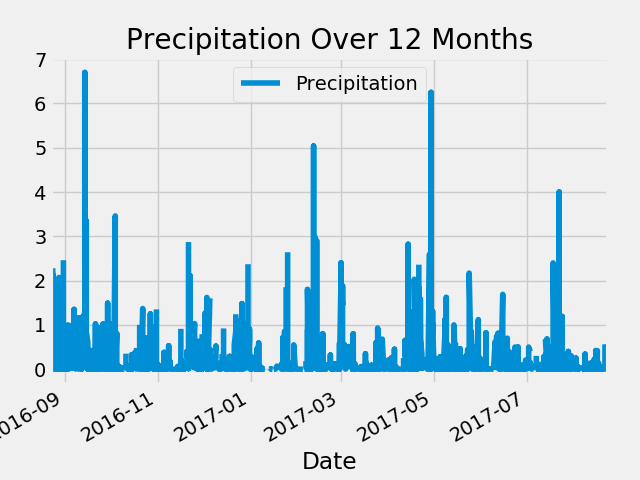

In [8]:
#Design a Query to Retrieve the Last 12 Months of Data on Precipitation and Plot the Results
previous_twelve_months_dates = session.query(Measurement.date).order_by(Measurement.date.desc()).first()

most_recent_date = previous_twelve_months_dates[0]
print(most_recent_date)

#Calculate the Date 1 year Ago from Today
#Since 365 Days in Reverse Ends on the Date after the First Date, 366 Days Creates a Date for Start and End that are Equal
date_previous_year = dt.datetime.strptime(most_recent_date, "%Y-%m-%d") - dt.timedelta(days=366)

#Perform a Query to Retrieve the Data and Scores for Precipitation
query_precipitation = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= date_previous_year).all()

#Save the Results of Query as DataFrame in Pandas and Set the Index to Column of Date
precipitation_df = pd.DataFrame(query_precipitation,columns=['Date', 'Precipitation'])

#Use Pandas to Convert the Dataframe to a Datetime Object
precipitation_df['Date'] = pd.to_datetime(precipitation_df['Date'], format='%Y-%m-%d')

#Set Index with Date in Place
precipitation_df.set_index('Date', inplace=True)

#Sort the Dataframe by Date
precipitation_df = precipitation_df.sort_values(by='Date',ascending=True)

#Use Pandas Plotting with Matplotlib to Plot the Data
precipitation_df.plot(title="Precipitation Over 12 Months")
plt.legend(loc='upper center')
plt.savefig("Images/Precipitation.png")
plt.show()

In [9]:
#Use Pandas to Calculate the Summary of Statistics for the Data on Precipitation
precipitation_df.describe()

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [10]:
#Design a Query to Determine the Number of Stations Available in the Dataset?
stations_available = session.query(Measurement.station).distinct().count()
print(f"Stations Available: {stations_available} ")

Stations Available: 9 


In [11]:
#What are the Most Active Stations?
#List the Stations and the Counts in Descending Order.
most_active_stations = session.query(Measurement.station,func.count(Measurement.station)).group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()
print("Most Active Stations")
most_active_stations

Most Active Stations


[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [12]:
#Use the First Station in a List in Descending Order to Determine the Most Active Station 
most_active_station=most_active_stations[0][0]
print(f"Most Active Station: {most_active_station}")

Most Active Station: USC00519281


In [13]:
#Use the Identification for Station from the Previous Query, Calculate the Lowest Recorded Temperature, 
#the Highest Recorded Temperature, and the Average Recorded Temperature for the Most Active Station
most_active_station_temperatures = session.query(func.min(Measurement.tobs), func.max(Measurement.tobs),
                                                 func.avg(Measurement.tobs)).filter(Measurement.station == most_active_station).all()
print(f"Most Active Station Temperatures")
print(f"Low: {most_active_station_temperatures[0][0]} High: {most_active_station_temperatures[0][1]} Average: {round(most_active_station_temperatures[0][2], 1)}")

Most Active Station Temperatures
Low: 54.0 High: 85.0 Average: 71.7


<IPython.core.display.Javascript object>


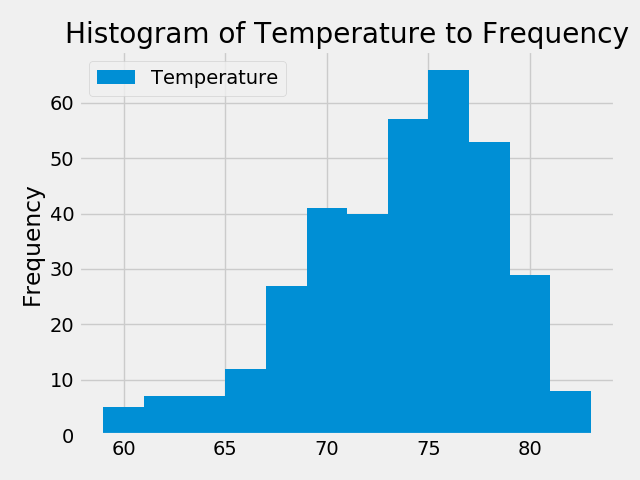

In [14]:
#Choose the Station with the Highest Number of Observations of Temperature.
stations_most_observations = session.query(Measurement.station, func.count(Measurement.tobs)).group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).first()
station_most_observations= stations_most_observations[0]

#Query the Last 12 Months of Data of Observations of Temperature for the Station and Plot the Results as a Histogram
observations_temperature = session.query( Measurement.tobs).filter(Measurement.date >= date_previous_year).filter(Measurement.station == station_most_observations).all()
observations_temperature_df = pd.DataFrame(observations_temperature, columns=['Temperature'])

#Use Matplotlib to Plot the Data
observations_temperature_df.plot.hist(bins=12, title="Histogram of Temperature to Frequency")
plt.tight_layout()
plt.savefig("Images/TemperaturetoFrequency.png")
plt.show()

In [15]:
#Create the Function "calc_temps" to Accept Dates for Start and End in the Format ""%Y-%m-%d",
#and Return the Minimum, Average, and Maximum Temperatures for the Range of Dates
def calc_temps(start_date, end_date):

    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


### Analysis of Climate for Trip ###

In [16]:
#Use the Function `calc_temps` to Calculate the tmin, tavg, and tmax 
#for the Trip with the Data of the Previous Year for the Same Dates.
trip_temperatures = calc_temps('2017-08-01','2017-08-15')
trip_temperatures

[(70.0, 78.8688524590164, 84.0)]

<IPython.core.display.Javascript object>


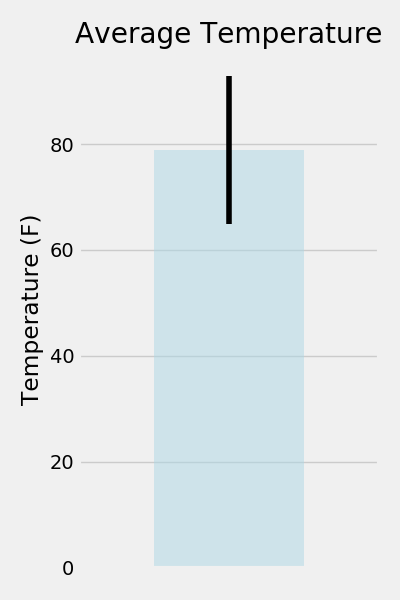

In [17]:
#Create a dataframe with the calculated tmin, tavg, and tmax values
trip_temperatures_df = pd.DataFrame(trip_temperatures, columns=['tmin', 'tavg', 'tmax'])


#Plot the Results of the Previous Query as a Bar Chart.
#Use the Average Temperature for the Y-Value
#Use the Peak-to-Peak (tmax-tmin) Value as the Y-Error Bar (yerr)
trip_temperatures_df.plot.bar(y='tavg', yerr=(trip_temperatures_df['tmax'] - trip_temperatures_df['tmin']), title='Average Temperature', color='lightblue', alpha=0.5, figsize=(4,6))
plt.xticks(np.arange(1, 1.0))
plt.ylabel("Temperature (F)")
plt.tight_layout()
plt.gca().legend_.remove()
plt.savefig("Images/AverageTemperatureTrip.png")
plt.show()

In [18]:
#Calculate the rainfall per weather station for your trip dates using the previous year's matching dates.
#Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
def precipitation(start_date, end_date):
    
    """Precipitation information per weather station
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        A list of tuples containing precipitation amount, station, name, latitude, longitude, and elevation in descending order.
    """
    
    sel = [Measurement.station, 
           Station.name, 
           Station.latitude, 
           Station.longitude, 
           Station.elevation, 
           Measurement.prcp]
    
    return session.query(*sel).\
            filter(Measurement.station == Station.station).filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).group_by(Measurement.station).order_by(Measurement.prcp.desc()).all()

print(precipitation('2017-08-01','2017-08-15'))

[('USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0, 0.12), ('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 0.02), ('USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9, 0.0), ('USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5, 0.0), ('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4, None)]
